In [27]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors

import numpy as np 
import pandas as pd

from matplotlib import colormaps
from chromato.spaces import convert

import fastf1
import fastf1.plotting
from fastf1 import utils 

import os

cache_folder = 'cache_folder'
if not os.path.exists(cache_folder):
    os.makedirs(cache_folder)
fastf1.Cache.enable_cache(cache_folder)

fastf1.plotting.setup_mpl(mpl_timedelta_support=True, misc_mpl_mods=False,
                          color_scheme='fastf1')

#year = int(input('Year ? '))
#race_number = int(input('Race Number ? (1-24) '))
#race_session = input('Session ? (Q, SQ) ')

year = 2025
race_number = 11
race_session = 'Q'

session = fastf1.get_session(year, race_number, race_session)
session.load()

q1, q2, q3 = session.laps.split_qualifying_sessions()
is_nat = np.isnat(q1['LapTime'])
q1 = q1[~is_nat]
is_nat = np.isnat(q2['LapTime'])
q2 = q2[~is_nat]
is_nat = np.isnat(q3['LapTime'])
q3 = q3[~is_nat]
if race_session == 'Q':
    filename = f'/home/kurios/Documents/f1_analysis/reports/figures/{race_number}_{session.event["EventName"]}_{session.event.year}_Qualifying/'
elif race_session == 'SQ':
    filename = f'/home/kurios/Documents/f1_analysis/reports/figures/{race_number}_{session.event["EventName"]}_{session.event.year}_Sprint Qualifying/'

os.makedirs(os.path.dirname(filename), exist_ok=True)
os.chdir(filename)

event_name = session.event.EventName
circuit_info = session.get_circuit_info()
teams = fastf1.plotting.list_team_names(session)

core           INFO 	Loading data for Austrian Grand Prix - Qualifying [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO

/tmp/ipykernel_7404/1136901313.py:423: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(18, 4.5))


No data in Q3 for Aston Martin
No data in Q3 for Williams
No data in Q3 for Haas F1 Team


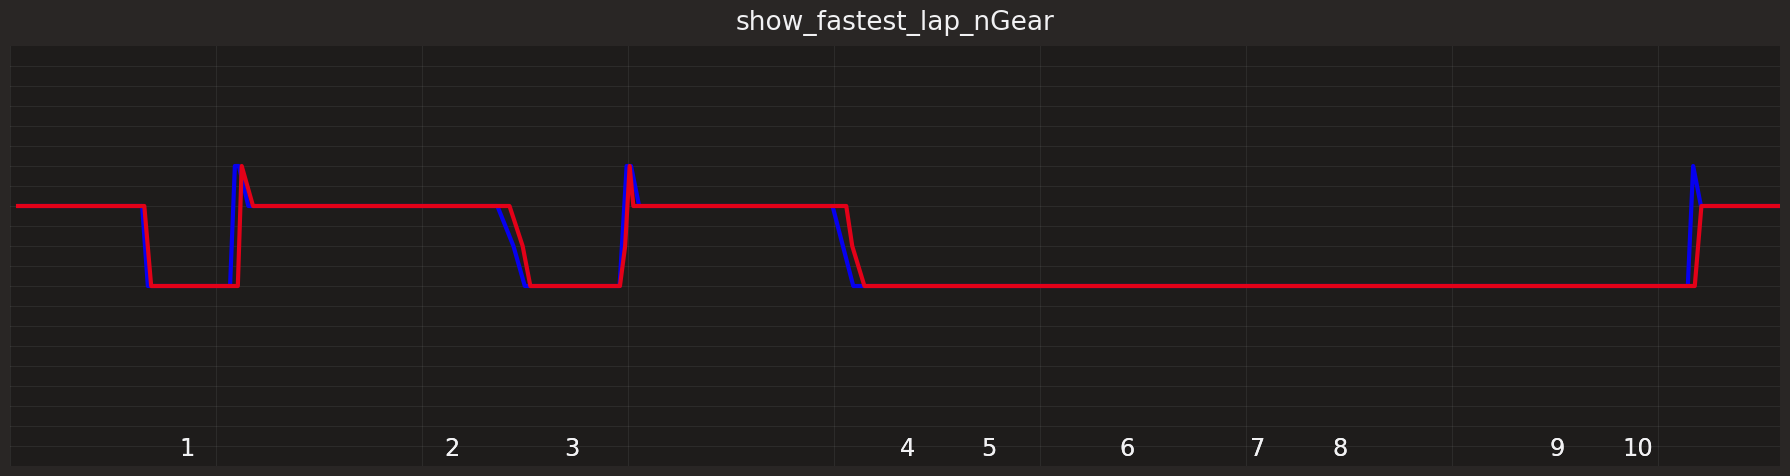

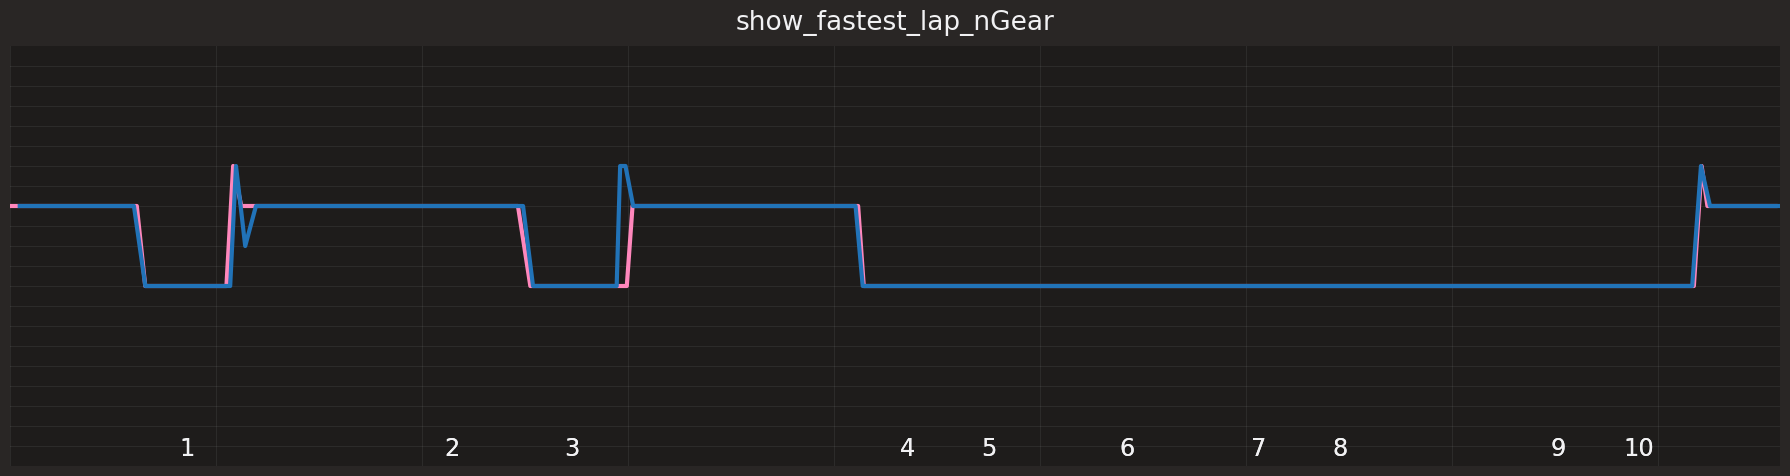

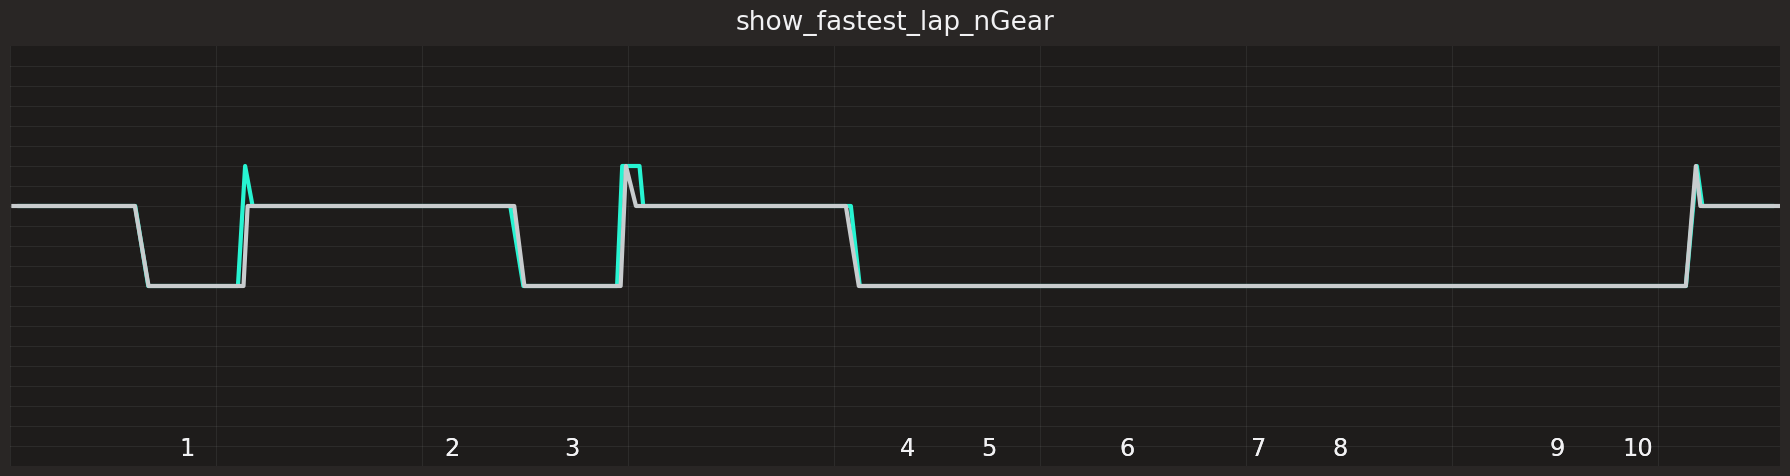

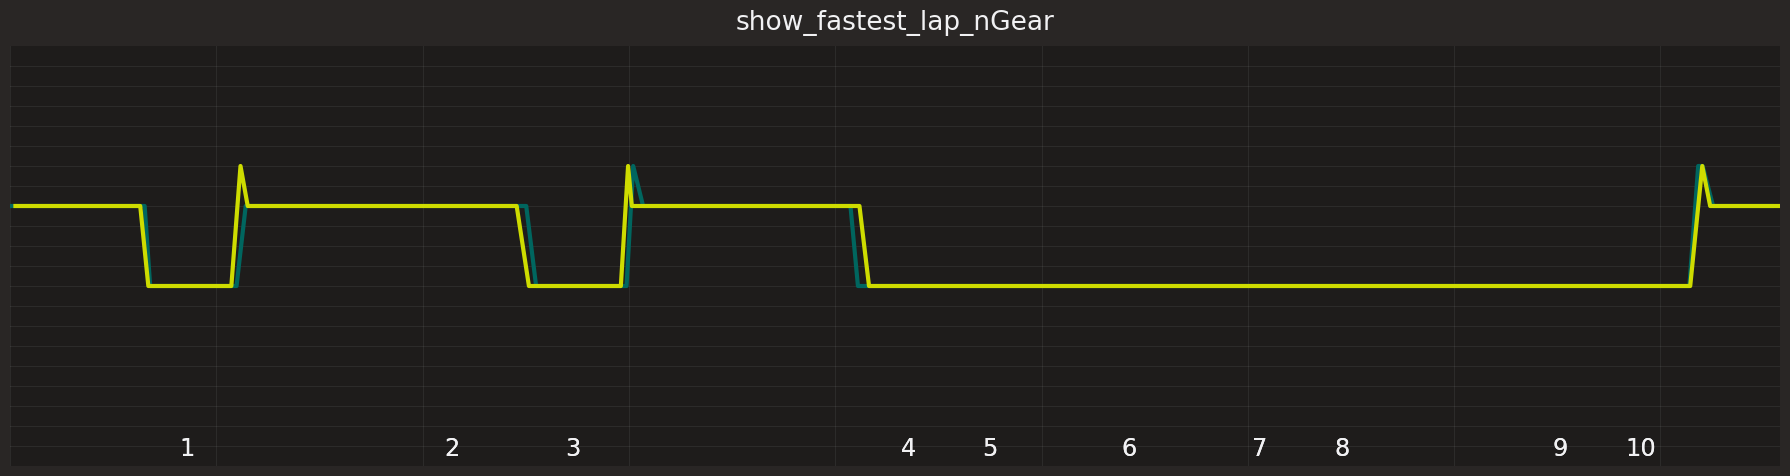

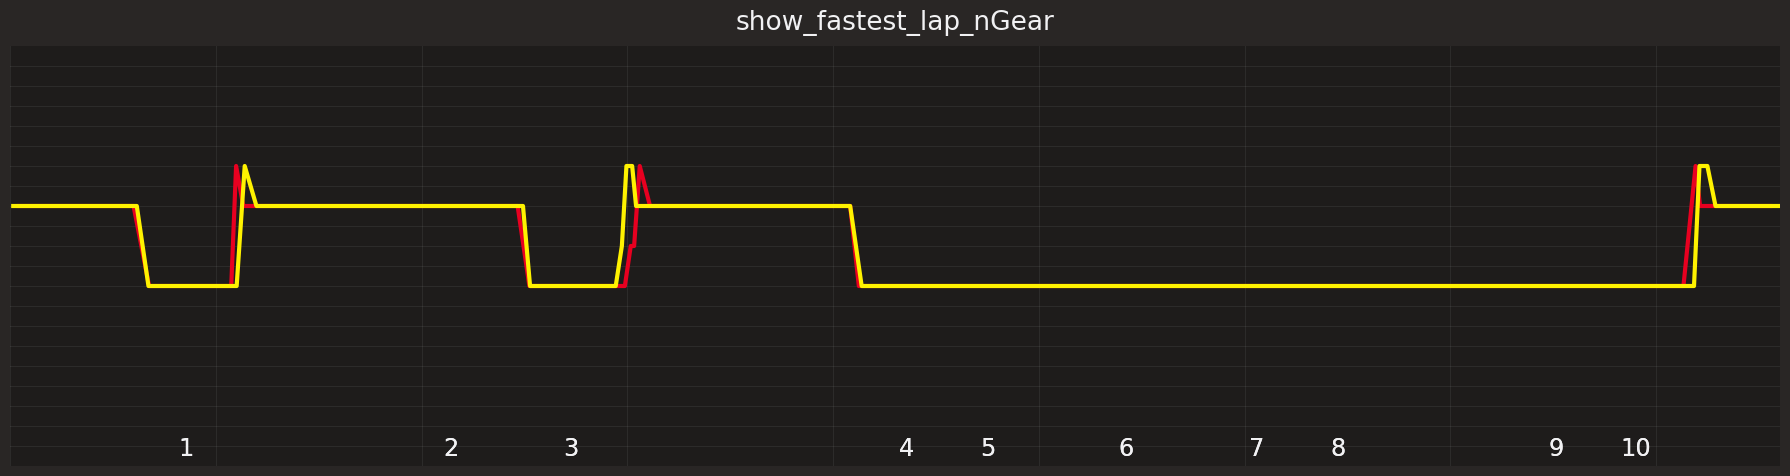

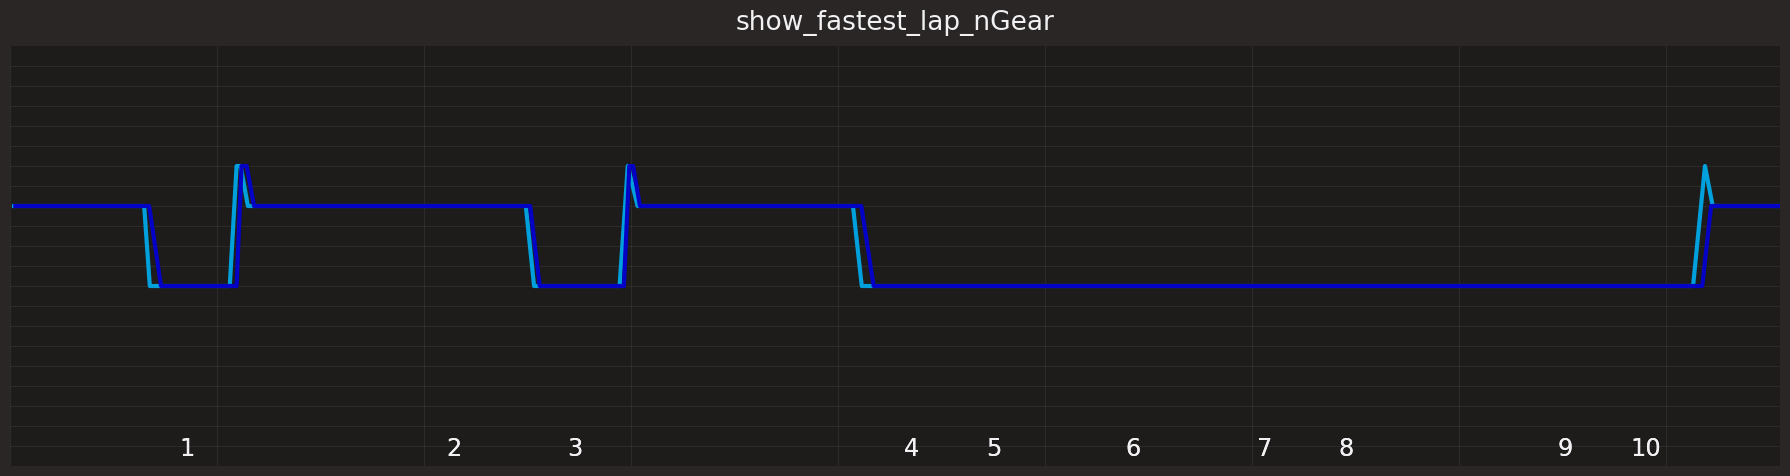

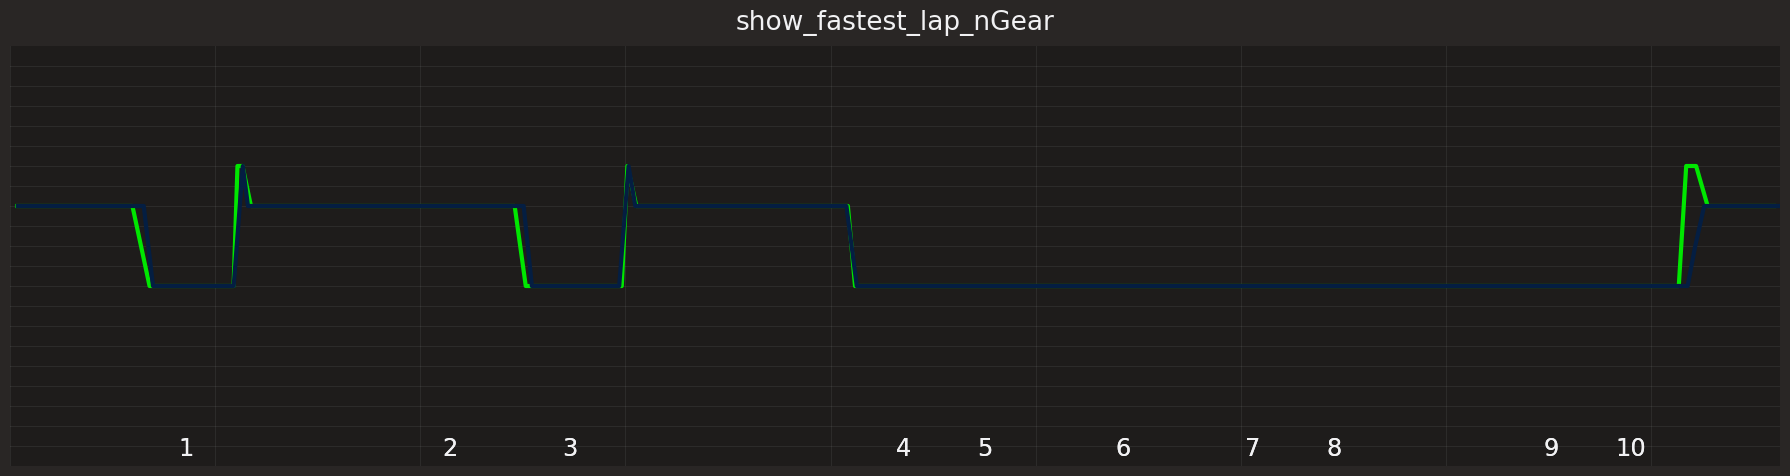

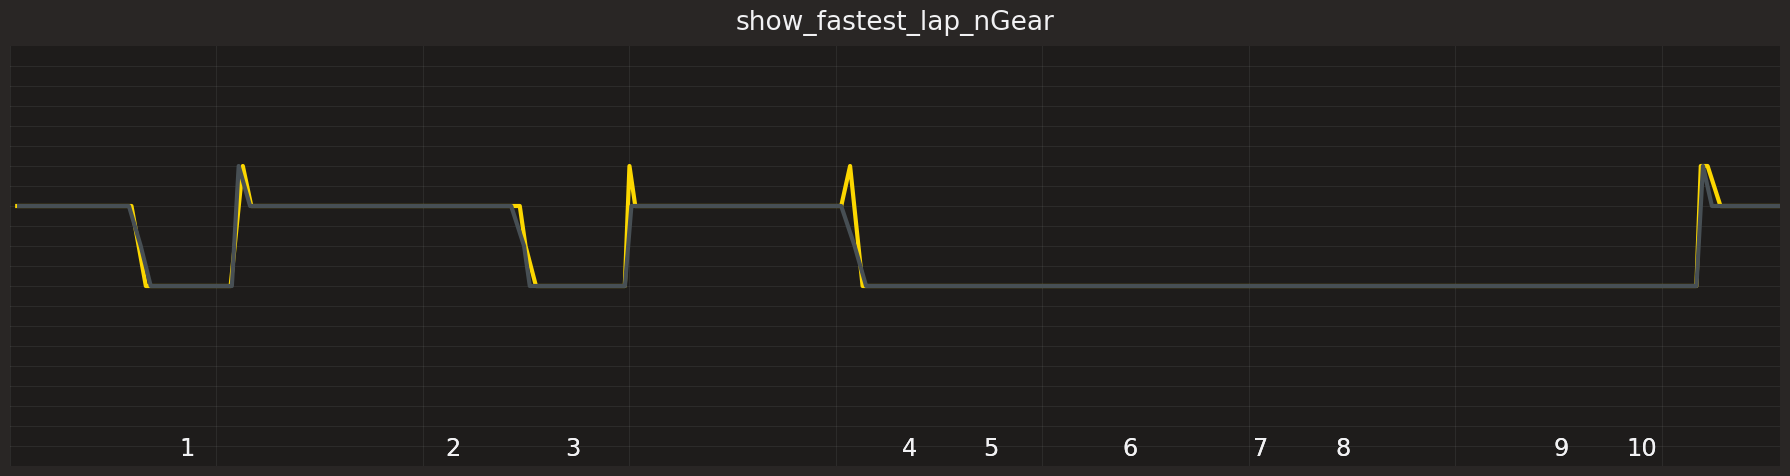

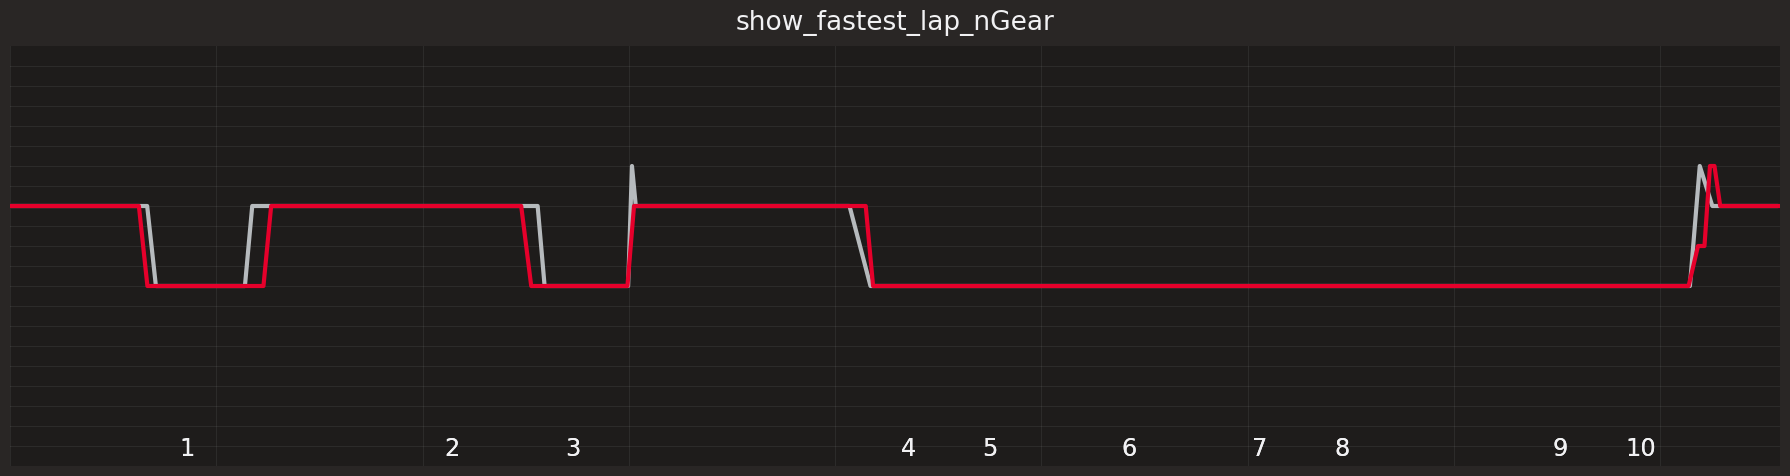

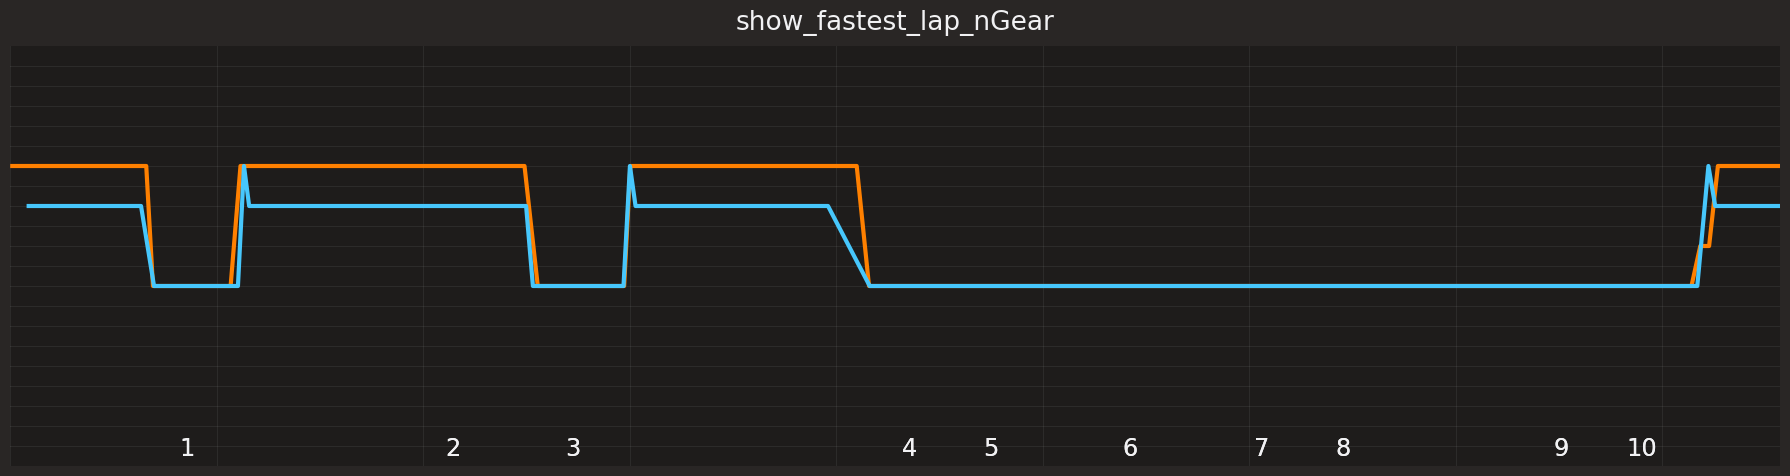

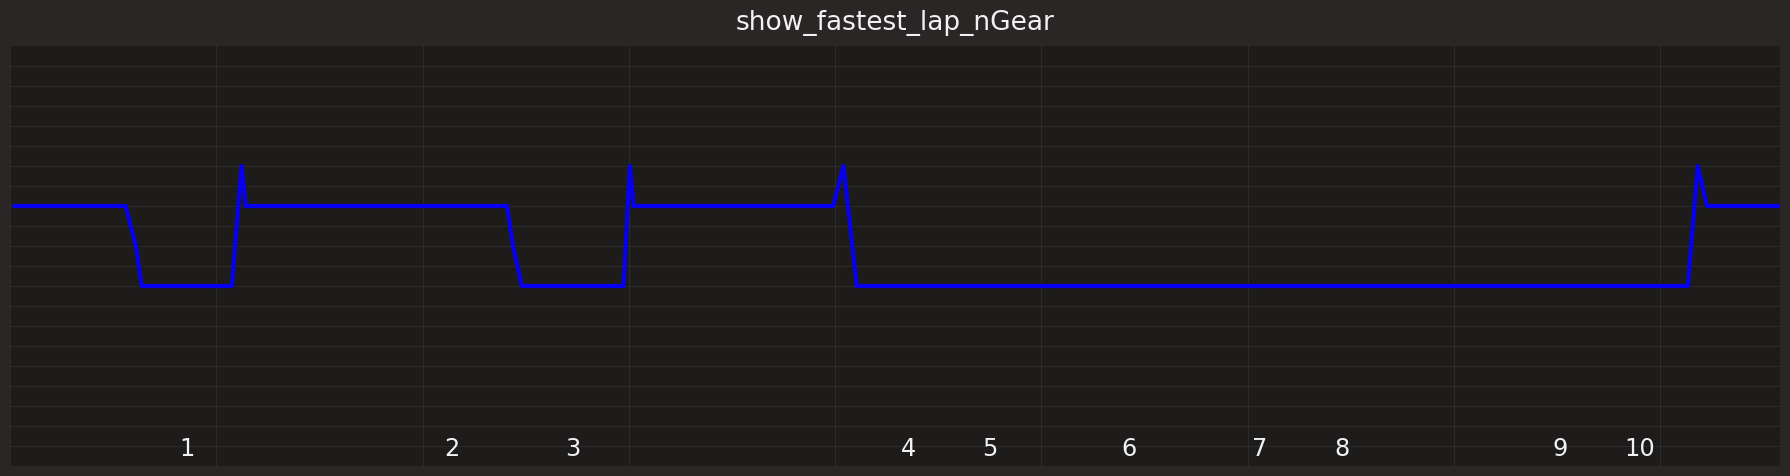

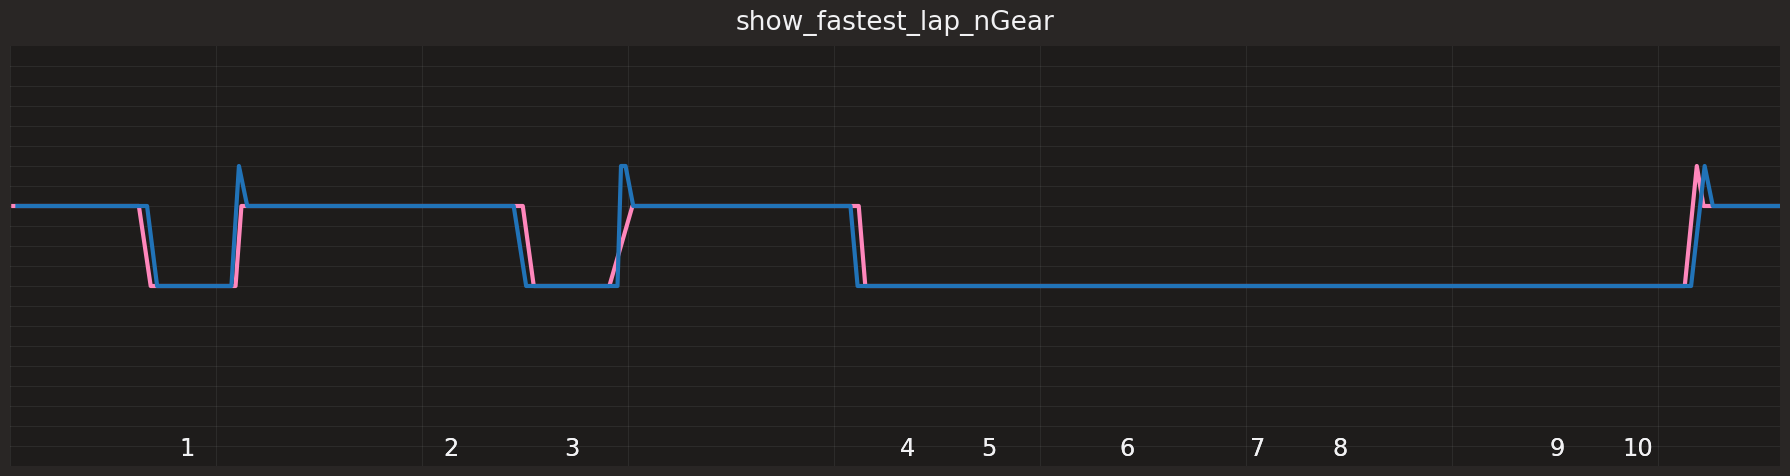

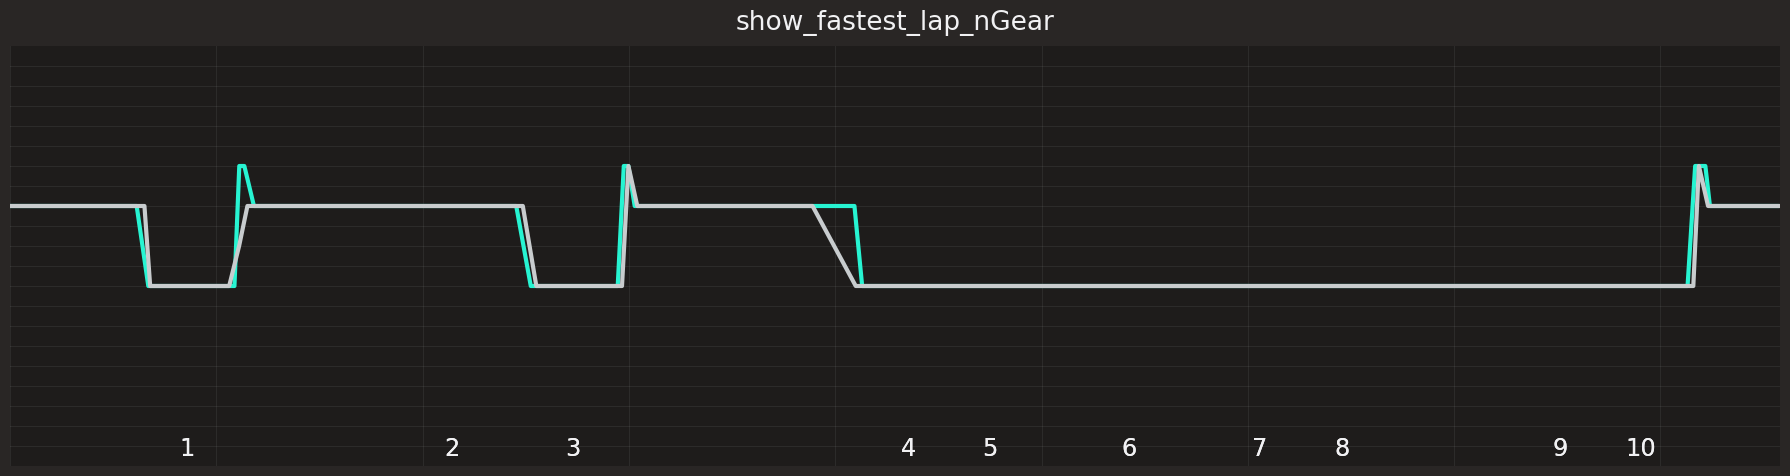

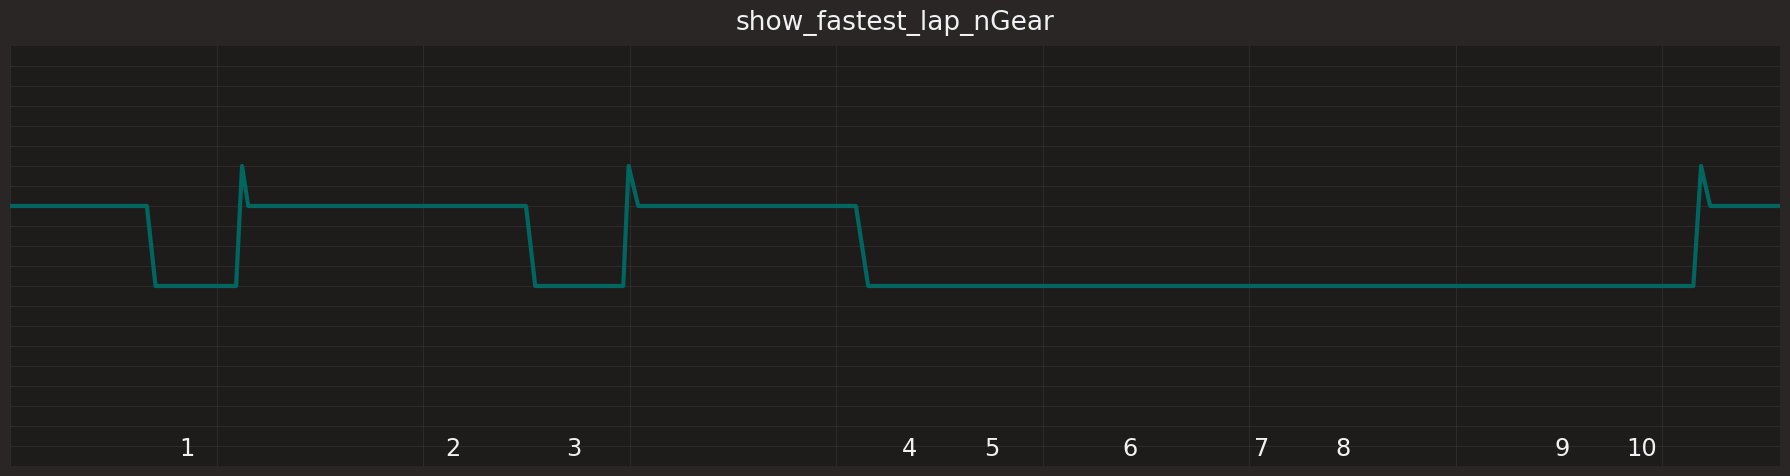

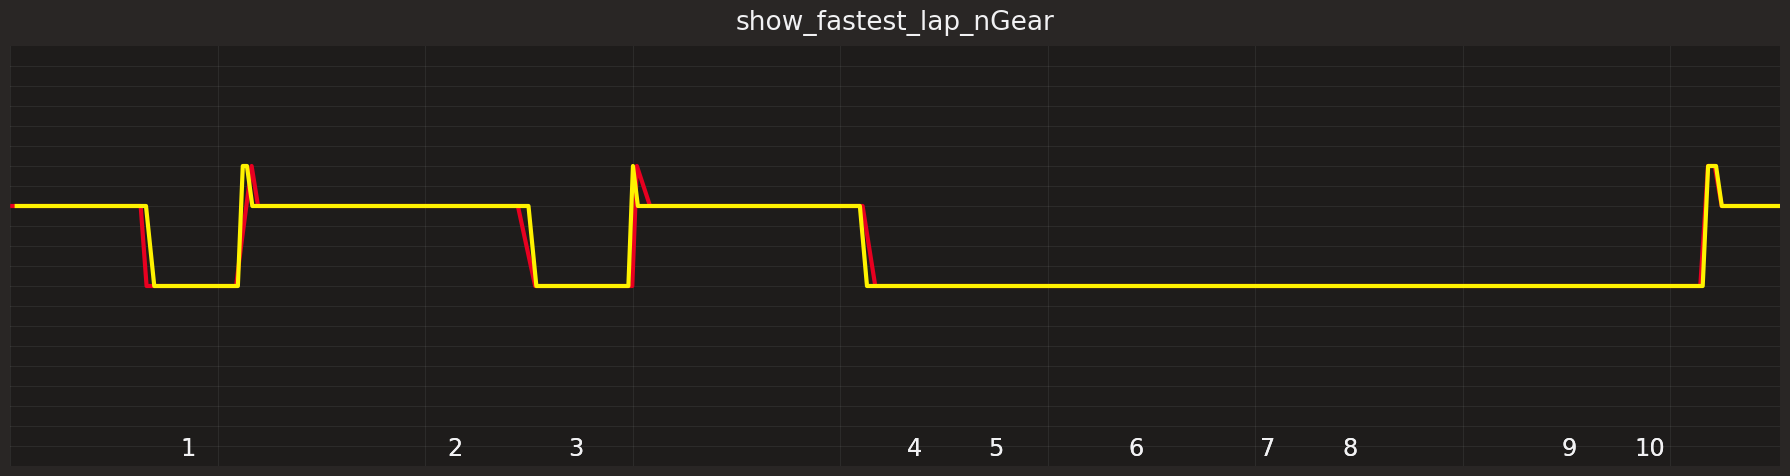

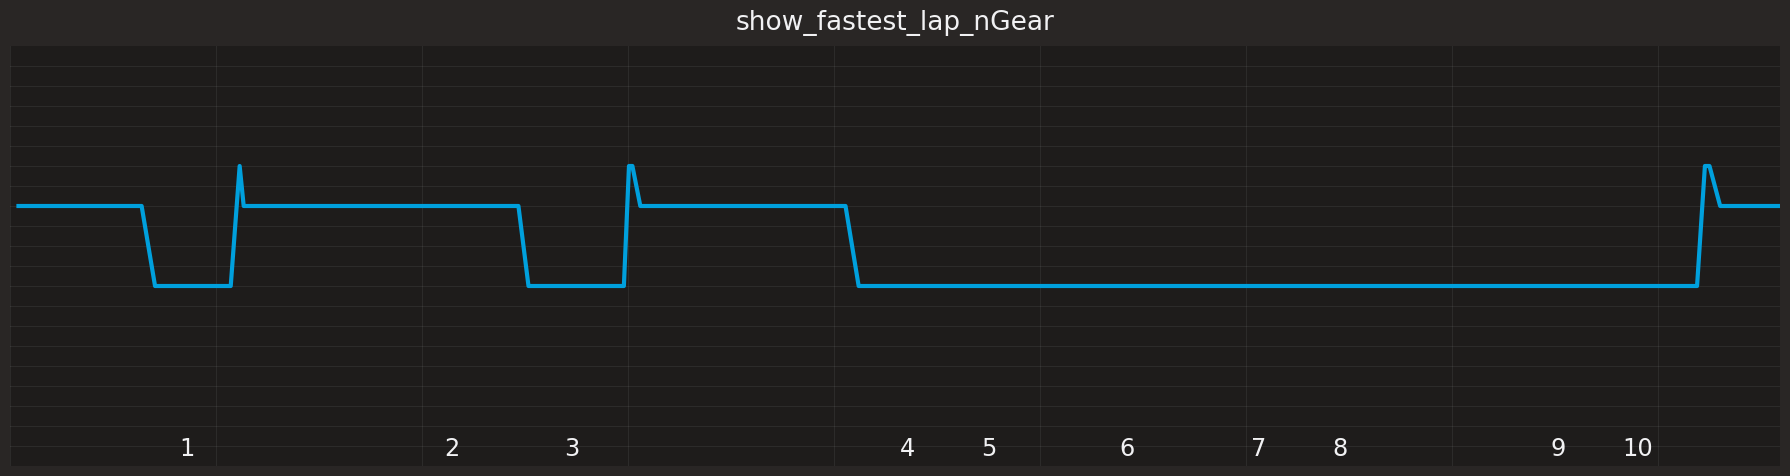

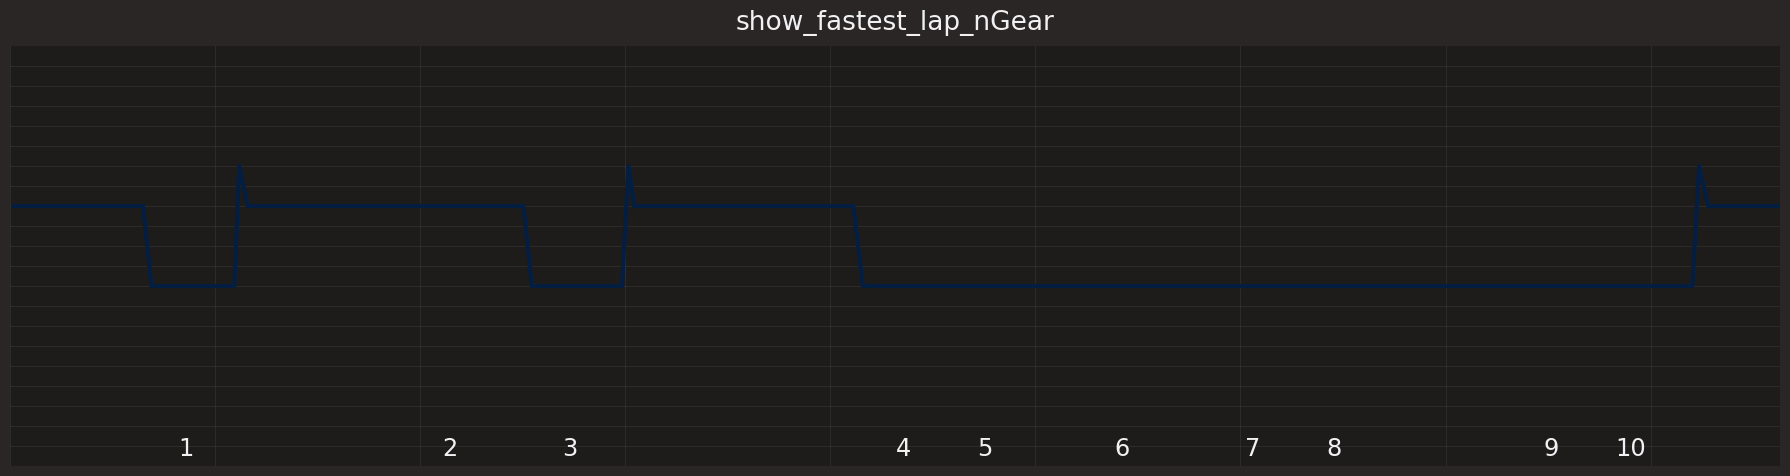

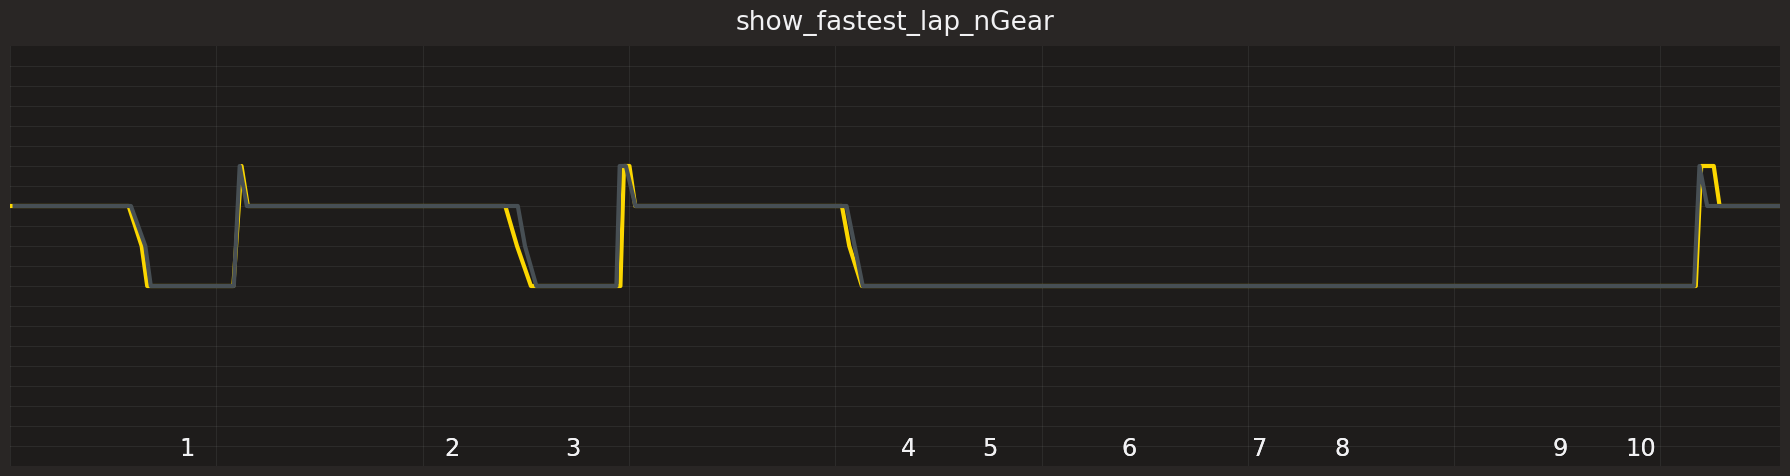

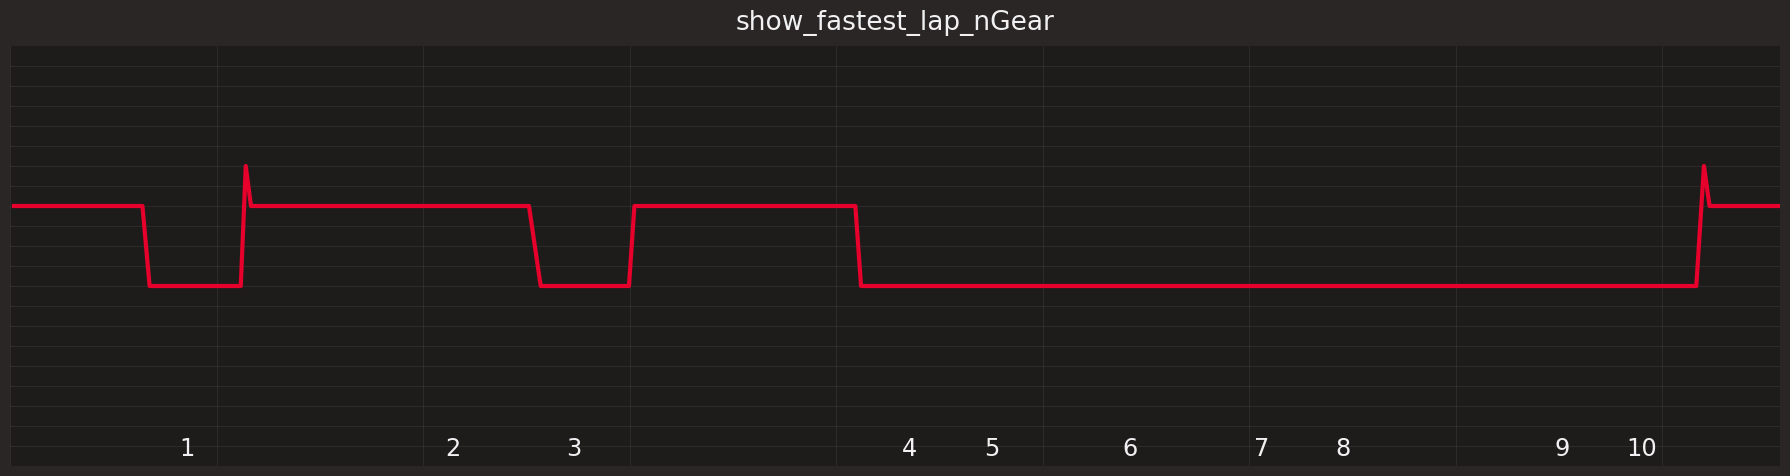

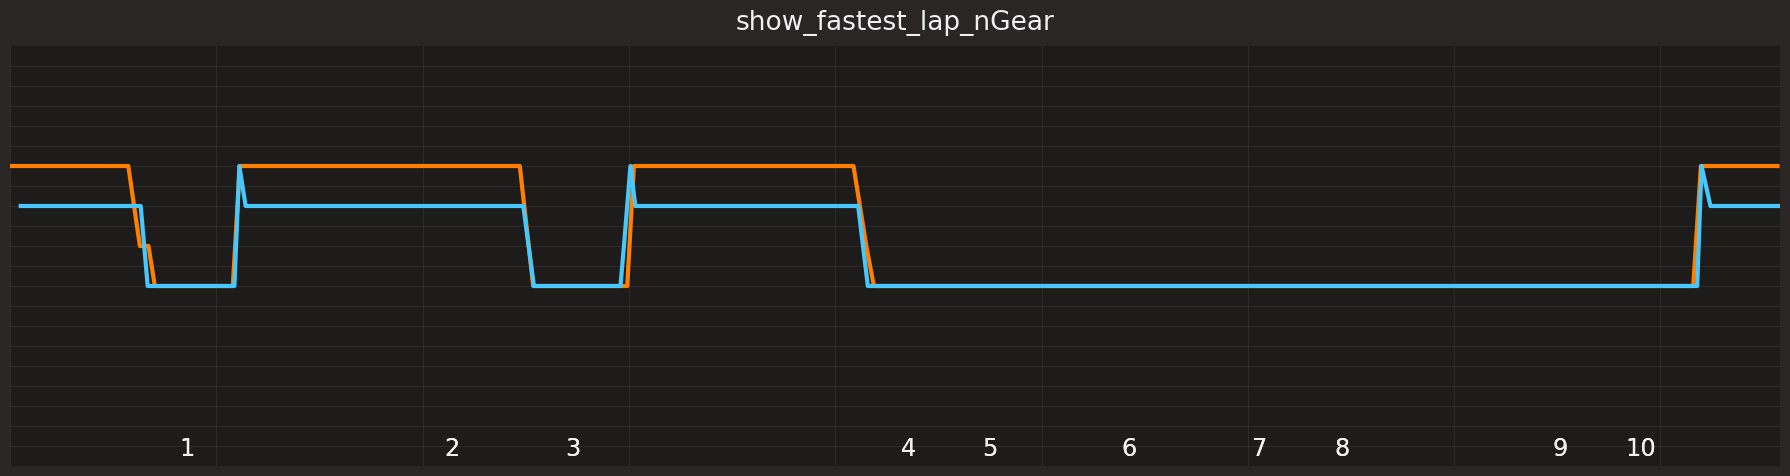

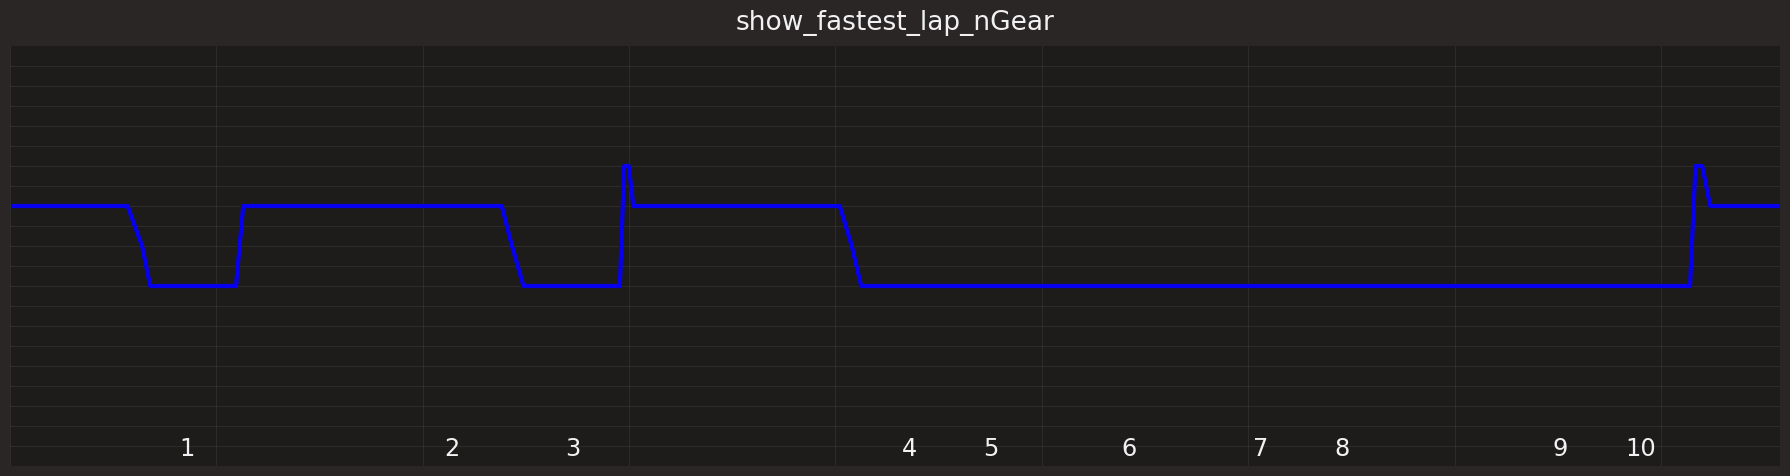

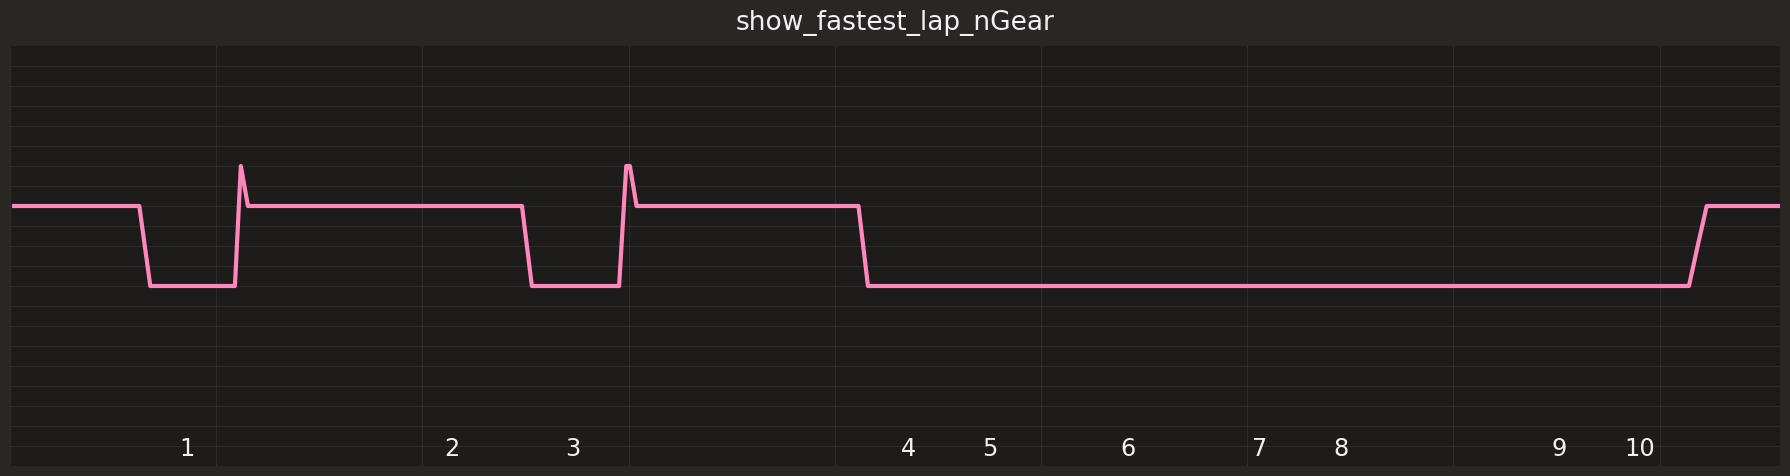

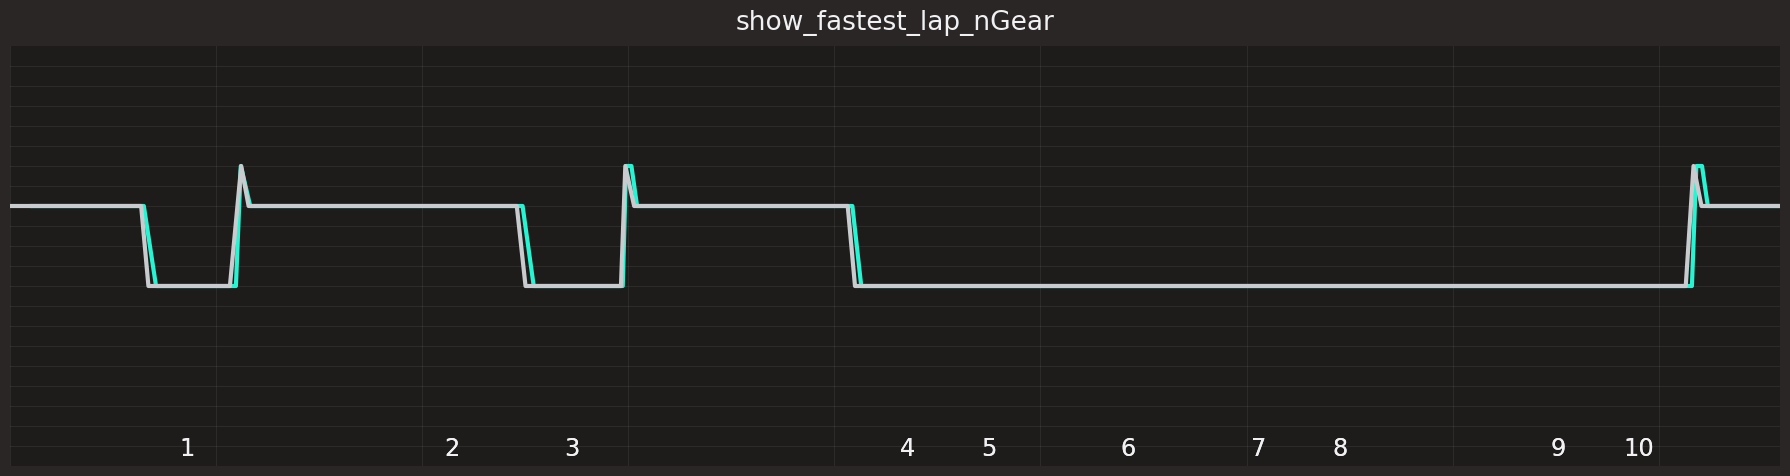

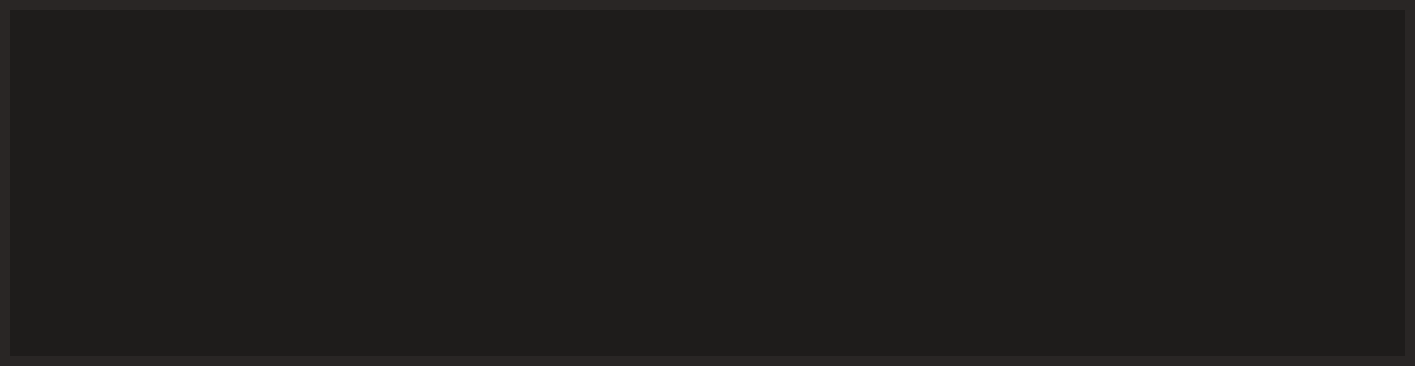

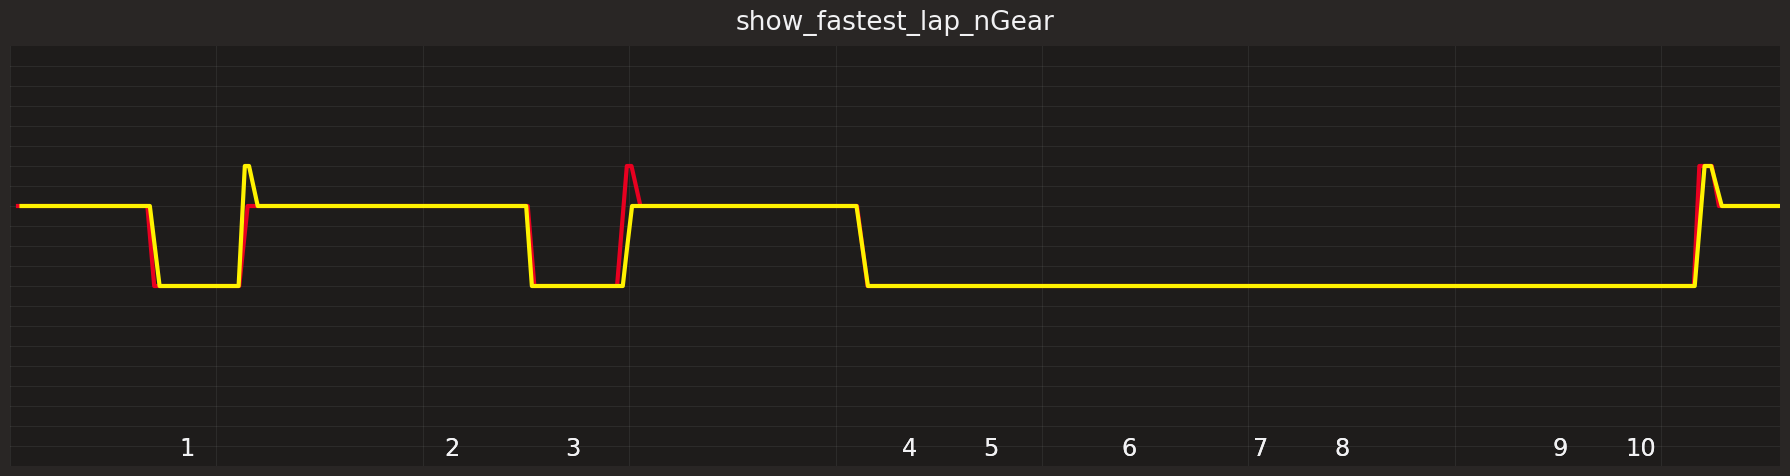

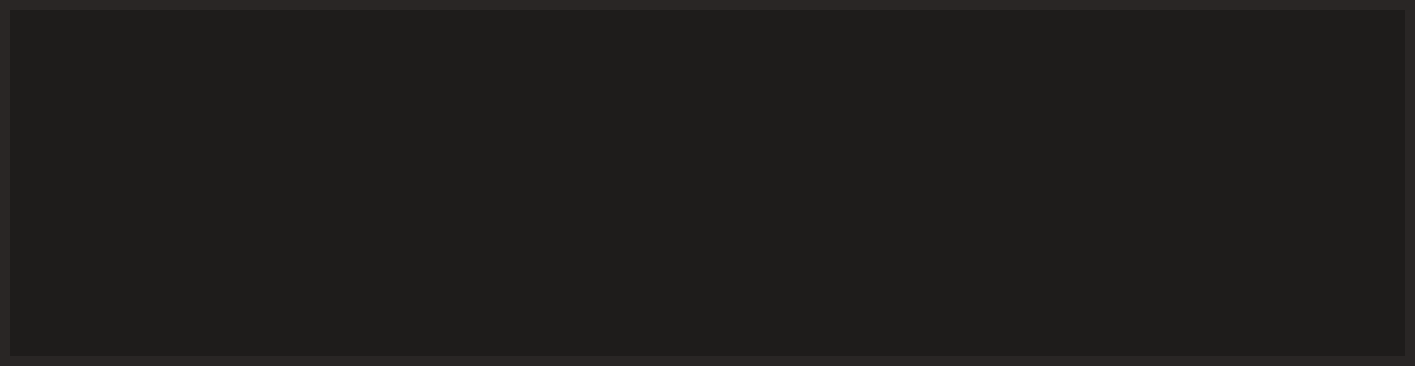

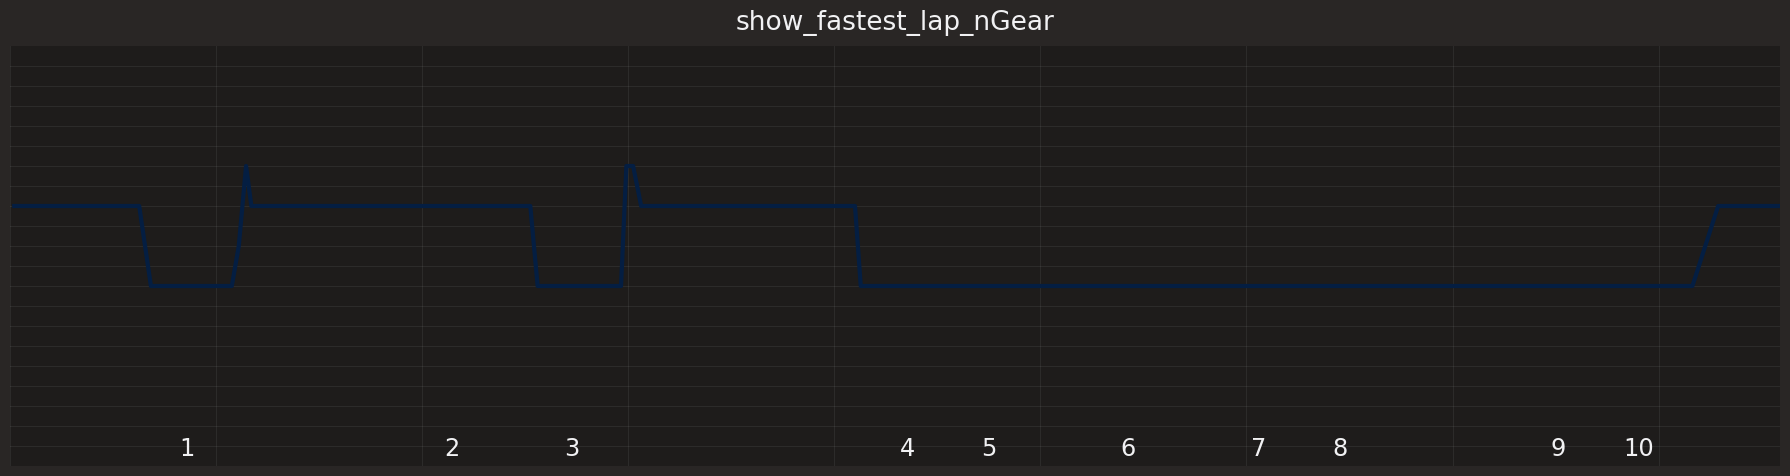

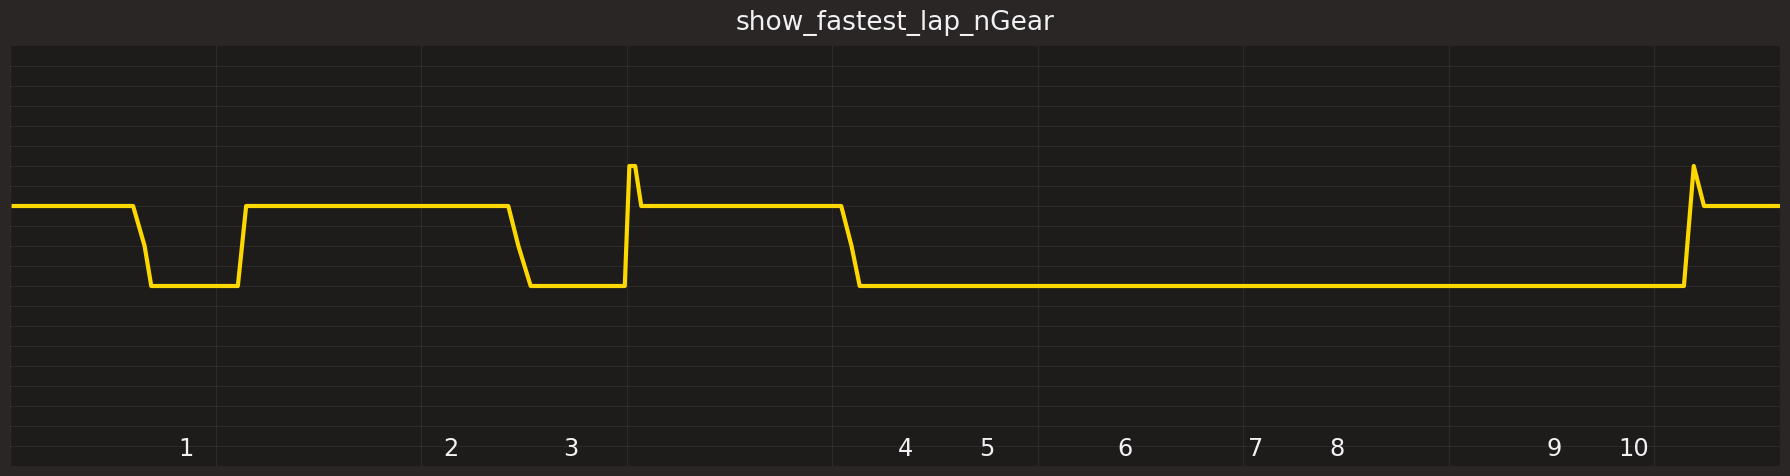

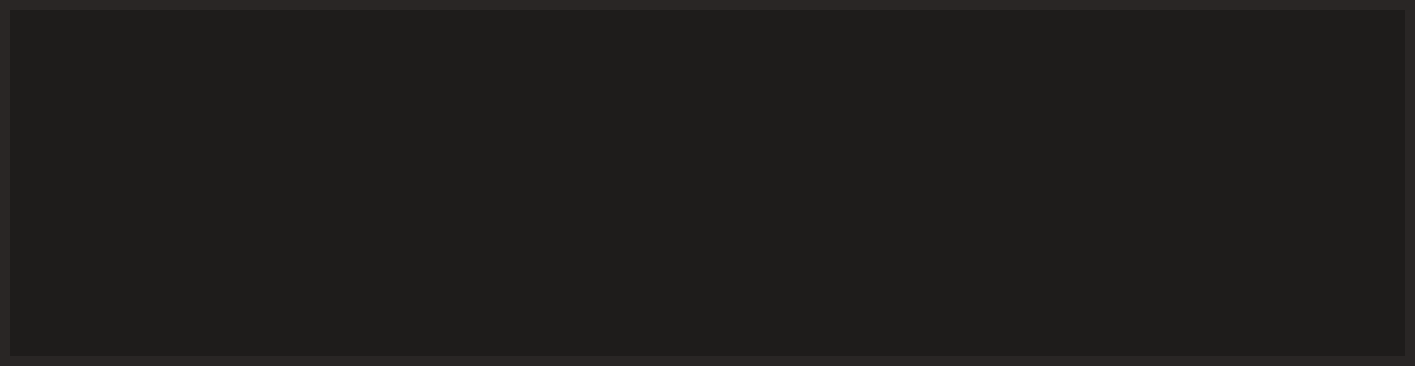

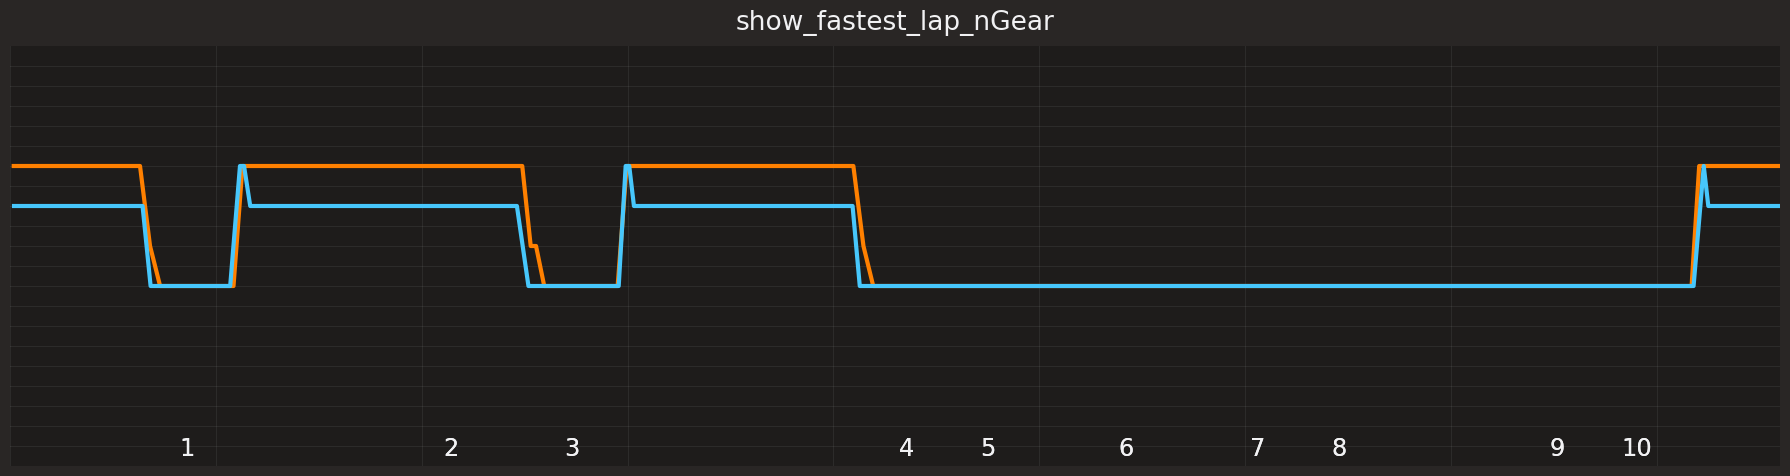

In [30]:
def rotate(xy, *, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)],
                        [-np.sin(angle), np.cos(angle)]])
    return np.matmul(xy, rot_mat)

def get_corner_dist_for_drivers(driver_tel):
    driver_corner_distance = []
    i= 0 
    for index, row in driver_tel.iterrows():
        distance = row['Distance']
        if i == len(circuit_info.corners):
            break
        elif distance > circuit_info.corners['Distance'][i]:
            driver_corner_distance.append(row)
            i+=1
    return driver_corner_distance

def add_turn(driver_tel):

    driver_distance = get_corner_dist_for_drivers(driver_tel)
    
    list_turn = []
    for i in range(len(driver_distance)):
        list_turn.append(driver_distance[i]['Distance'])
        
    turn_values = list(range(1, len(list_turn) + 1)) 
    list_turn = np.array([entry['Distance'] for entry in driver_distance])
    values = driver_tel['Distance'].values
    turn = np.zeros_like(values, dtype=int)
    for i, val in enumerate(values):
        for j in range(0, len(list_turn)): 
            if val <= list_turn[j]:
                turn[i] = turn_values[j]
                break
    return turn

def add_faster_driver(driver_tel, faster_driver, corner_distance):
    
    values = driver_tel['Turn'].values
    faster = np.zeros_like(values, dtype=int)
    for i, val in enumerate(faster_driver):
        if val == 1 :
            faster[values == i+1] = 1 
    return faster

def convert_for_cmap(base_color):
    base_color_rgb = convert.hex_to_rgb(base_color)
    r = base_color_rgb.r/255
    g = base_color_rgb.g/255
    b = base_color_rgb.b/255
    
    return r, g, b

def get_delta_per_team(team_drivers, quali_session):
    driver_1_lap = quali_session.pick_drivers(team_drivers[0]).pick_fastest()
    driver_2_lap = quali_session.pick_drivers(team_drivers[1]).pick_fastest()
    
    if type(driver_1_lap) != type(None) and type(driver_2_lap) != type(None):
        delta_time, ref_tel, compare_tel = utils.delta_time(driver_1_lap, driver_2_lap)
        max_delta = max(abs(min(delta_time)), abs(max(delta_time))) + 0.1 

    delta_time_at_corner = [0]
    for idx_corner, corner in circuit_info.corners.iterrows():
            for idx_dist ,dist in ref_tel['Distance'].items():
                    if dist > corner['Distance']:
                            delta_time_at_corner.append(round(delta_time[idx_dist],3))
                            break
    delta_time_at_corner_diff = np.diff(delta_time_at_corner).tolist()
    delta_time_at_corner_diff = [round(elem, 3) for elem in delta_time_at_corner_diff]
    delta_per_team.update({f'{subsession_name}_{team}': delta_time_at_corner_diff})
    return delta_per_team

def show_corner_advantage_per_quali_session(team_drivers, quali_session):
    gaps = [1 if gap >= 0 else 0 for gap in delta_per_team[f'{subsession_name}_{team}']]

    lap = session.laps.pick_drivers(team_drivers[0]).pick_fastest()
    tel = lap.get_telemetry()
    tel['Turn'] = add_turn(tel)
    corner_distance = circuit_info.corners['Distance']
    tel['faster_driver'] = add_faster_driver(tel, gaps, corner_distance)
    x = np.array(tel['X'].values)
    y = np.array(tel['Y'].values)
    
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    track_angle = circuit_info.rotation / 180 * np.pi
    rotated_track = rotate(points, angle=track_angle)
    segments = np.concatenate([rotated_track[:-1], rotated_track[1:]], axis=1)
    first_values = [pair[0][0] for pair in rotated_track]
    second_values = [pair[0][1] for pair in rotated_track]
    
    cmap = colormaps['Paired']

    tc_r , tc_g, tc_b = convert_for_cmap(team_color) 
    tc_r2 , tc_g2, tc_b2 = convert_for_cmap(team_color_2) 

    cdict = {
        'red': (
            (0.0, 0.0, tc_r2),
            (0.0, 0.0, 0.1),
            (1.0, tc_r, 1.0),
        ),
        'green': (
            (0.0, 0.0, tc_g2),
            (0.0, 0.0, 0.0),
            (1.0, tc_g, 0.0),
        ),
        'blue': (
            (0.0, 0.0, tc_b2),
            (0.0, 0.0, 0.0),
            (1.0, tc_b, 0.0),
        )
    }

    cmap = mcolors.LinearSegmentedColormap('my_colormap', cdict)
    lc_comp = LineCollection(segments,linewidths=4, cmap=cmap)
    lc_comp.set_array(tel['faster_driver'])

    plt.rcParams['axes.spines.left'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.bottom'] = False
    
    fig, ax = plt.subplots(figsize=(5, 5))
    
    plt.plot(first_values, second_values,
        color='grey', linestyle='-', linewidth=8)
    plt.plot(rotated_track[0], rotated_track[1])
    offset_vector = [1000, 0] 

    offset_angle = 1 / 180 * np.pi
    offset_x, offset_y = rotate(offset_vector, angle=offset_angle)
    txt_sl ='Start / Finish Line'
    txt_sl_x = tel['X'].iloc[0] + offset_x
    txt_sl_y = tel['Y'].iloc[0] + offset_y
    txt_sl_x, txt_sl_y = rotate([txt_sl_x, txt_sl_y], angle=track_angle)
    plt.text(txt_sl_x, txt_sl_y, txt_sl,
             va='center_baseline', ha='center', size='small', weight='bold', color='white')
    
    for _, corner in circuit_info.corners.iterrows():
        txt = f"{corner['Number']}{corner['Letter']}" 
        
        offset_angle = corner['Angle'] / 180 * np.pi
        offset_x, offset_y = rotate(offset_vector, angle=offset_angle)

        text_x = corner['X'] + offset_x
        text_y = corner['Y'] + offset_y
        text_x, text_y = rotate([text_x, text_y], angle=track_angle)

        plt.text(text_x, text_y, txt,
                va='center_baseline', ha='center', size=16, weight='bold', color='white')
    
    plt.gca().add_collection(lc_comp)
    plt.axis('equal')
    plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
    fig.tight_layout()
    plt.savefig(fname=f'{subsession_name}_{team}_corner_domination', transparent=True)

    
def create_bar_graph_per_driver(team_drivers, quali_session):
    team_drivers = fastf1.plotting.get_driver_abbreviations_by_team(team, session=session)
    driver_1_lap = quali_session.pick_drivers(team_drivers[0]).pick_fastest()
    driver_2_lap = quali_session.pick_drivers(team_drivers[1]).pick_fastest()
    if type(driver_1_lap) != type(None) and type(driver_2_lap) != type(None) :
        
        driver_1_tel = driver_1_lap.get_car_data()
    
        full_throttle = round(len(np.where(driver_1_tel['Throttle'].values >= 90)[0])/len(driver_1_tel)*100)
        brake = round(len(np.where(driver_1_tel['Brake'] == True)[0])/len(driver_1_tel)*100)
        cornering = 100 - full_throttle - brake

        driver_2_tel = driver_2_lap.get_car_data()
    
        full_throttle1 = round(len(np.where(driver_2_tel['Throttle'].values >= 90)[0])/len(driver_2_tel)*100)
        brake1 = round(len(np.where(driver_2_tel['Brake'] == True)[0])/len(driver_2_tel)*100)
        cornering1 = 100 - full_throttle - brake
        
        keys=('Full Throttle','Braking', 'Cornering' )
        
        full_throttle_bar = np.array([100, full_throttle])
        brake_bar = np.array([100, brake])
        cornering_bar = np.array([100, cornering])
        plt.subplots(figsize=(5, 2))
        plt.tick_params(
            axis='both',
            which='both',
            bottom=False,
            left=False,
            labelleft=False,
            labelbottom=False)
        plt.barh(keys[2], cornering_bar, height=0.4 ,color = ['#696969', team_color])
        plt.barh(keys[1], brake_bar, height=0.4, color = ['#696969', team_color])
        plt.barh(keys[0], full_throttle_bar, height=0.4, color = ['#696969', team_color ])
        plt.rcParams['axes.spines.left'] = False
        plt.rcParams['axes.spines.right'] = False
        plt.rcParams['axes.spines.top'] = False
        plt.rcParams['axes.spines.bottom'] = False
        plt.savefig(fname=f'{subsession_name}_{team}_driver_1_bar_graph', transparent=True)

        
        full_throttle_bar1 = np.array([100, full_throttle1])
        brake_bar1 = np.array([100, brake1])
        cornering_bar1 = np.array([100, cornering1])
        plt.subplots(figsize=(5, 2))
        plt.barh(keys[2], cornering_bar1, height=0.4, color = ['#696969', team_color_2 ])
        plt.barh(keys[1], brake_bar1, height=0.4, color = ['#696969', team_color_2])
        plt.barh(keys[0], full_throttle_bar1, height=0.4, color = ['#696969', team_color_2 ])
        plt.gca().invert_xaxis()
        plt.rcParams['axes.spines.left'] = False
        plt.rcParams['axes.spines.right'] = False
        plt.rcParams['axes.spines.top'] = False
        plt.rcParams['axes.spines.bottom'] = False
        plt.tick_params(
            axis='both',
            which='both',
            bottom=False,
            left=False,
            labelleft=False,
            labelbottom=False)
        plt.savefig(fname=f'{subsession_name}_{team}_driver_2_bar_graph', transparent=True)


def show_driver_quali_dif_per_lap(team_drivers, quali_session):
    driver_1_lap = quali_session.pick_drivers(team_drivers[0]).pick_fastest()
    driver_2_lap = quali_session.pick_drivers(team_drivers[1]).pick_fastest()
    
    plt.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelleft=False,
        labelbottom=False)  
    plt.rcParams['axes.spines.left'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.bottom'] = False  
    
    fig, ax = plt.subplots(figsize=(13, 2.5))
        
    if type(driver_1_lap) != type(None) and type(driver_2_lap) != type(None):
            delta_time, ref_tel, compare_tel = utils.delta_time(driver_1_lap, driver_2_lap)
            max_delta = max(abs(min(delta_time)), abs(max(delta_time))) + 0.1 
            ax.vlines(x=circuit_info.corners['Distance'], ymin=-max_delta, ymax=max_delta, colors='white', linestyle='dotted')
            plt.axhline(y=0, color= team_color_2, linewidth=3)
            ax.plot(ref_tel['Distance'], delta_time, color=team_color, linewidth=3)
    
    delta_time_at_corner = [0]
    for idx_corner, corner in circuit_info.corners.iterrows():
            for idx_dist ,dist in ref_tel['Distance'].items():
                    if dist > corner['Distance']:
                            delta_time_at_corner.append(round(delta_time[idx_dist],3))
                            break
    delta_time_at_corner.append(round(delta_time.iloc[-1],3))
    delta_time_at_corner_diff = np.diff(delta_time_at_corner).tolist()
    delta_time_at_corner_diff = [round(elem, 3) for elem in delta_time_at_corner_diff]
    delta_per_team.update({f'{subsession_name}_{team}': delta_time_at_corner_diff})
    
    plt.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelleft=False,
        labelbottom=False)
    plt.ylim(-max_delta, max_delta)
    plt.xlim(0, max(ref_tel['Distance']))
    
    minor_xticks = np.arange(0, max(ref_tel['Distance']), max(ref_tel['Distance'])/100)
    minor_yticks = np.arange(-max_delta, max_delta, (max_delta)/6)
    ax.set_xticks(minor_xticks, minor=True, labels=None)
    ax.set_yticks(minor_yticks, minor=True, labels=None)
    ax.grid(which='minor', alpha=0.1)
    plt.xlim(0, max(ref_tel['Distance']))
    fig.tight_layout()
    plt.rcParams['axes.spines.left'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.bottom'] = False
    plt.savefig(fname=f'{subsession_name}_{team}_deltatime', transparent=True)

    
def show_fastest_lap_per_quali_session(team_drivers, quali_session):
    fig, ax = plt.subplots(figsize=(13, 4.5))
    plt.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelleft=False,
        labelbottom=False)
    driver_1_lap = quali_session.pick_drivers(team_drivers[0]).pick_fastest()
    driver_2_lap = quali_session.pick_drivers(team_drivers[1]).pick_fastest()
    car_data = driver_1_lap.get_car_data().add_distance()
    
    if type(driver_1_lap) != type(None) and type(driver_2_lap) != type(None):
            delta_time, ref_tel, compare_tel = utils.delta_time(driver_1_lap, driver_2_lap)
    for driver in team_drivers:
        driver_lap = quali_session.pick_drivers(driver).pick_fastest()
        v_min = car_data['Speed'].min()
        v_max = car_data['Speed'].max()
                        
        if type(driver_lap) != type(None):
            
            driver_tel = driver_lap.get_car_data().add_distance()

            car_data = driver_lap.get_car_data().add_distance()
            
            for _, corner in circuit_info.corners.iterrows():
                txt = f"{corner['Number']}{corner['Letter']}"
                ax.text(corner['Distance'], v_min-(v_min*0.4), txt,
                        va='center_baseline', ha='center', size='xx-large')

            if driver == team_drivers[0] :
                ax.vlines(x=circuit_info.corners['Distance'], ymin = -v_min - 20 , ymax = v_max + 30, colors='white', linestyle='dotted')
                ax.plot(driver_tel['Distance'], driver_tel['Speed'], color=team_color, linewidth=3)
            else:
                ax.plot(driver_tel['Distance'], driver_tel['Speed'], color=team_color_2, linewidth=3)
    
    minor_xticks = np.arange(0, max(ref_tel['Distance']), max(ref_tel['Distance'])/100)
    minor_yticks = np.arange(v_min -20, v_max + 20, (v_max + 20)/30)
    ax.set_ylim([v_min - 20, v_max + 20])
    ax.set_xticks(minor_xticks, minor=True, labels=None)
    ax.set_yticks(minor_yticks, minor=True, labels=None)
    ax.grid(which='minor', alpha=0.1)
    plt.xlim(0, max(ref_tel['Distance']))
    
    fig.tight_layout()
    plt.rcParams['axes.spines.left'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.bottom'] = False
    plt.savefig(fname=f'{subsession_name}_{team}_speed', transparent=True)

def show_fastest_lap_throttle(team_drivers, quali_session):
    fig, ax = plt.subplots(figsize=(18, 4.5))
    plt.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelleft=False,
        labelbottom=False)

    for driver in team_drivers:
        driver_lap = quali_session.pick_drivers(driver).pick_fastest()

        if type(driver_lap) != type(None):
            
            driver_tel = driver_lap.get_car_data().add_distance()

            for _, corner in circuit_info.corners.iterrows():
                txt = f"{corner['Number']}{corner['Letter']}"
                ax.text(corner['Distance'], -10, txt,
                        va='center_baseline', ha='center', size='xx-large')

            if driver == team_drivers[0] :
                #ax.vlines(x=circuit_info.corners['Distance'], colors='white', linestyle='dotted')
                ax.plot(driver_tel['Distance'], driver_tel['Throttle'], color=team_color, linewidth=3)
            else:
                ax.plot(driver_tel['Distance'], driver_tel['Throttle'], color=team_color_2, linewidth=3)
    
    minor_xticks = np.arange(0, max(driver_tel['Distance']), max(driver_tel['Distance'])/10)
    minor_yticks = np.arange(-10, 110, 10)
    ax.set_ylim([-10, 110])
    ax.set_xticks(minor_xticks, minor=True)
    ax.set_yticks(minor_yticks, minor=False)
    ax.grid(which='major', alpha=0.1)
    plt.xlim(0, max(driver_tel['Distance']))
    
    fig.tight_layout()
    plt.rcParams['axes.spines.left'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.bottom'] = False
    plt.title("show_fastest_lap_throttle")
    #plt.savefig(fname=f'{subsession_name}_{team}_speed', transparent=True)

def show_fastest_lap_nGear(team_drivers, quali_session):
    fig, ax = plt.subplots(figsize=(18, 4.5))
    plt.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelleft=False,
        labelbottom=False)

    for driver in team_drivers:
        driver_lap = quali_session.pick_drivers(driver).pick_fastest()

        if type(driver_lap) != type(None):
            
            driver_tel = driver_lap.get_car_data().add_distance()

            for _, corner in circuit_info.corners.iterrows():
                txt = f"{corner['Number']}{corner['Letter']}"
                ax.text(corner['Distance'], 0, txt,
                        va='center_baseline', ha='center', size='xx-large')

            if driver == team_drivers[0] :
                #ax.vlines(x=circuit_info.corners['Distance'], colors='white', linestyle='dotted')
                ax.plot(driver_tel['Distance'], driver_tel['nGear'], color=team_color, linewidth=3)
            else:
                ax.plot(driver_tel['Distance'], driver_tel['nGear'], color=team_color_2, linewidth=3)
    
    minor_xticks = np.arange(0, max(driver_tel['Distance']), max(driver_tel['Distance'])/10)
    minor_yticks = np.arange(0, 9, 1)
    ax.set_ylim([0, 9])
    ax.set_xticks(minor_xticks, minor=True)
    ax.set_yticks(minor_yticks, minor=False)
    ax.grid(which='major', alpha=0.1)
    plt.xlim(0, max(driver_tel['Distance']))
    
    fig.tight_layout()
    plt.rcParams['axes.spines.left'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.bottom'] = False
    plt.title("show_fastest_lap_nGear")
    #plt.savefig(fname=f'{subsession_name}_{team}_speed', transparent=True)

def show_fastest_lap_DRS(team_drivers, quali_session):
    fig, ax = plt.subplots(figsize=(18, 4.5))
    plt.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelleft=False,
        labelbottom=False)

    for driver in team_drivers:
        driver_lap = quali_session.pick_drivers(driver).pick_fastest()

        if type(driver_lap) != type(None):
            
            driver_tel = driver_lap.get_car_data().add_distance()

            for _, corner in circuit_info.corners.iterrows():
                txt = f"{corner['Number']}{corner['Letter']}"
                ax.text(corner['Distance'], 0, txt,
                        va='center_baseline', ha='center', size='xx-large')

            if driver == team_drivers[0] :
                #ax.vlines(x=circuit_info.corners['Distance'], colors='white', linestyle='dotted')
                ax.plot(driver_tel['Distance'], driver_tel['DRS'], color=team_color, linewidth=3)
            else:
                ax.plot(driver_tel['Distance'], driver_tel['DRS'], color=team_color_2, linewidth=3)
    
    minor_xticks = np.arange(0, max(driver_tel['Distance']), max(driver_tel['Distance'])/10)
    minor_yticks = np.arange(-1, 20, 1)
    ax.set_ylim([-1, 20])
    ax.set_xticks(minor_xticks, minor=True)
    ax.set_yticks(minor_yticks, minor=False)
    ax.grid(which='major', alpha=0.1)
    plt.xlim(0, max(driver_tel['Distance']))
    
    fig.tight_layout()
    plt.rcParams['axes.spines.left'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.bottom'] = False
    plt.title("show_fastest_lap_nGear")
    #plt.savefig(fname=f'{subsession_name}_{team}_speed', transparent=True)

def show_fastest_lap_rpm(team_drivers, quali_session):

    fig, ax = plt.subplots(figsize=(18, 4.5))
    plt.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelleft=False,
        labelbottom=False)

    for driver in team_drivers:
        driver_lap = quali_session.pick_drivers(driver).pick_fastest()

        if type(driver_lap) != type(None):
            
            driver_tel = driver_lap.get_car_data().add_distance()
            for _, corner in circuit_info.corners.iterrows():
                txt = f"{corner['Number']}{corner['Letter']}"
                ax.text(corner['Distance'], 4500, txt,
                        va='center_baseline', ha='center', size='xx-large')

            if driver == team_drivers[0] :
                ax.plot(driver_tel['Distance'], driver_tel['RPM'], color=team_color, linewidth=3)
            else:
                ax.plot(driver_tel['Distance'], driver_tel['RPM'], color=team_color_2, linewidth=3)
        
            major_yticks = np.arange(5000, 13000, 1000)
            ax.set_ylim([5000, 13000])
            ax.set_yticks(major_yticks, minor=False)
            ax.grid(which='major', alpha=0.1)
            #plt.xlim(0, max(driver_tel['Distance']))
            
            fig.tight_layout()
            plt.rcParams['axes.spines.left'] = False
            plt.rcParams['axes.spines.right'] = False
            plt.rcParams['axes.spines.top'] = False
            plt.rcParams['axes.spines.bottom'] = False
            plt.title("show_fastest_lap_rpm")
            #plt.savefig(fname=f'{subsession_name}_{team}_speed', transparent=True)
    

delta_per_team = {}
for subsession in [q1, q2, q3]:
    if subsession is q1:
        subsession_name = 'Q1'
    elif subsession is q2:
        subsession_name = 'Q2'
    elif subsession is q3:
        subsession_name = 'Q3'
    for idx, team in enumerate(teams):
        team_drivers = fastf1.plotting.get_driver_abbreviations_by_team(team, session=session)
        team_color = fastf1.plotting.get_team_color(team, session=session)
        df_color=pd.read_csv("/home/kurios/Documents/f1_analysis/data/raw/second_color.csv", index_col='team')
        team_color_2 = df_color.iat[idx,0]
        try:
            os.chdir(filename)
            #delta_per_team = get_delta_per_team(team_drivers, subsession)
            #show_driver_quali_dif_per_lap(team_drivers, subsession)
            #show_fastest_lap_per_quali_session(team_drivers, subsession)
            #show_fastest_lap_throttle(team_drivers, subsession)
            #show_fastest_lap_nGear(team_drivers, subsession)
            show_fastest_lap_DRS(team_drivers, subsession)
            #show_fastest_lap_rpm(team_drivers, subsession)
            #show_corner_advantage_per_quali_session(team_drivers=team_drivers, quali_session = subsession)
            #create_bar_graph_per_driver(team_drivers, subsession)
        except:
            print(f'No data in {subsession_name} for {team}')
        